In [31]:
import pandas as pd

import numpy as np

from datetime import datetime, timedelta



# Generate mock sales data

np.random.seed(42)

start_date = datetime(2020, 1, 1)

num_months = 48 # 4 years of monthly data

date_rng = pd.date_range(start_date, periods=num_months, freq='MS') # MS for Month Start



sales_data = pd.DataFrame(date_rng, columns=['Date'])



# Base sales with a slight upward trend

base_sales = 10000 + np.arange(num_months) * 50



# Seasonal component (higher in Q4, lower in Q1)

seasonal_component = (
    2000 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 12 + np.pi/2) 

    + 1500 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 6)

)

# Random noise

noise = np.random.normal(0, 500, num_months)



sales_data['SalesAmount'] = (base_sales + seasonal_component + noise).astype(int)

sales_data['SalesAmount'] = sales_data['SalesAmount'].clip(lower=2000) # Ensure sales are positive



# Add promotional flags (randomly)

sales_data['Promotion'] = np.random.choice([0, 1], num_months, p=[0.8, 0.2])

promo_boost = np.random.uniform(1.1, 1.3, sales_data['Promotion'].sum())
sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] = (
    sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'].values * promo_boost
).astype(int)



# Add holiday flags (e.g., December)

sales_data['HolidayMonth'] = (sales_data['Date'].dt.month == 12).astype(int)

holiday_boost = np.random.uniform(1.15, 1.4, sales_data['HolidayMonth'].sum())
sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] = (
    sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'].values * holiday_boost
).astype(int)



sales_data['SalesAmount'] = sales_data['SalesAmount'].astype(int)

In [32]:
sales_data.head()

,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,12248,0,0
1,2020-02-01,13011,0,0
2,2020-03-01,12722,0,0
3,2020-04-01,14030,1,0
4,2020-05-01,7783,0,0


In [97]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2020-06-01 to 2023-12-01
Freq: MS
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SalesAmount    43 non-null     int64         
 1   Promotion      43 non-null     int64         
 2   HolidayMonth   43 non-null     int64         
 3   Lag_1          43 non-null     float64       
 4   Lag_2          43 non-null     float64       
 5   Lag_3          43 non-null     float64       
 6   RollingMean_3  43 non-null     float64       
 7   RollingMean_6  43 non-null     float64       
 8   IsPromo        43 non-null     int64         
 9   IsHoliday      43 non-null     int64         
 10  Date           43 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 4.0 KB


## Converting Date to Index and setting Monthly Frequency

In [33]:
if "Date" not in sales_data.columns and sales_data.index.name == "Date":
    sales_data.reset_index(inplace = True)

sales_data["Date"] = pd.to_datetime(sales_data["Date"])
sales_data.set_index("Date" , inplace = True)

sales_data.sort_index(inplace = True)
sales_data.index.freq = "MS"

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalesAmount   48 non-null     int64
 1   Promotion     48 non-null     int64
 2   HolidayMonth  48 non-null     int64
dtypes: int64(3)
memory usage: 1.5 KB


## Converting Date to Index and setting Monthly Frequency

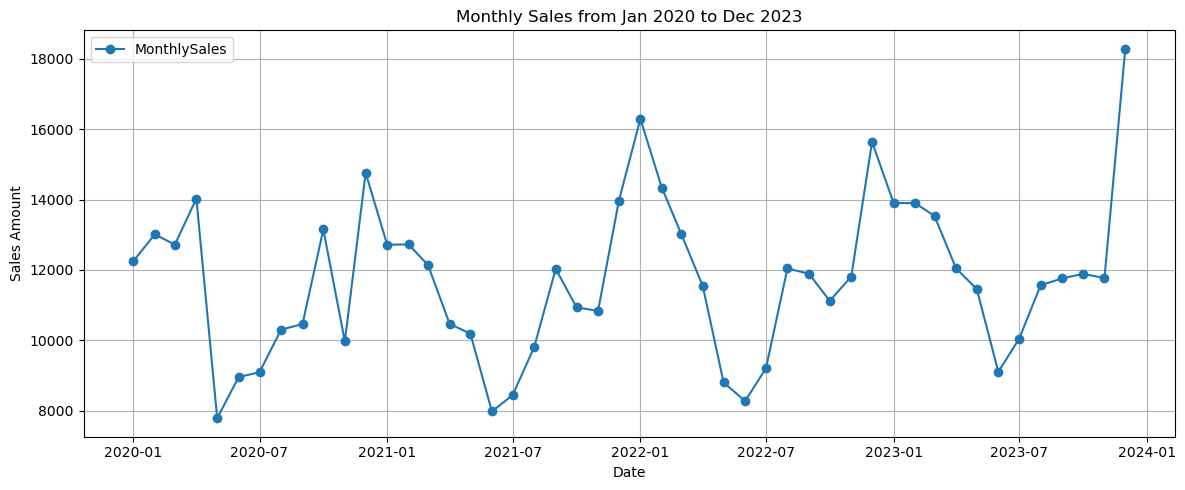

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12 , 5))
plt.plot(sales_data["SalesAmount"] , marker = "o" , label = "MonthlySales")
plt.title("Monthly Sales from Jan 2020 to Dec 2023")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Checking Missing values

In [35]:
print("Missing values:\n" , sales_data.isna().sum())

Missing values:
 SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64


## Seasonal Decomposition

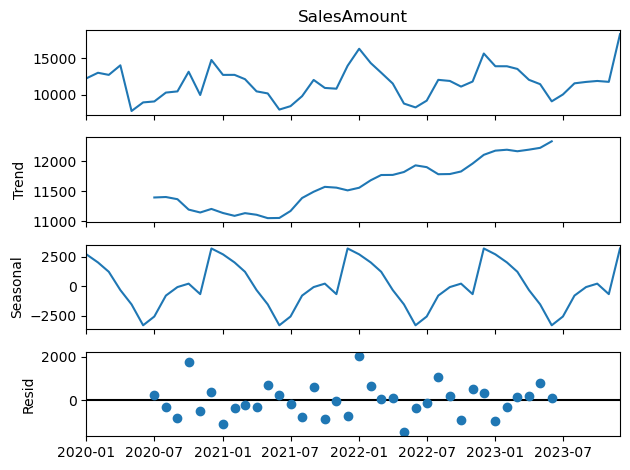

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sales_data["SalesAmount"] , model = "additive" , period = 12)

decomposition.plot()
plt.tight_layout()
plt.show()

## ADF Test

In [37]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_data["SalesAmount"])

print("ADF Statistics:" , result[0])
print("p-value:" , result[1])
for key , value in result[4].items():
    print(f"Critical Value({key}): {value}") 

ADF Statistics: -4.333890747860532
p-value: 0.0003878661736017112
Critical Value(1%): -3.596635636000432
Critical Value(5%): -2.933297331821618
Critical Value(10%): -2.6049909750566895


# Feature Enginnering

#### Creating Lag Features

In [38]:
for lag in [1 ,2 ,3]:
    sales_data[f"Lag_{lag}"] = sales_data["SalesAmount"].shift(lag)

sales_data["RollingMean_3"] = sales_data["SalesAmount"].rolling(window = 3).mean()
sales_data["RollingMean_6"] = sales_data["SalesAmount"].rolling(window = 6).mean()

sales_data["IsPromo"] = sales_data["Promotion"]
sales_data["IsHoliday"] = sales_data["HolidayMonth"]

sales_data.dropna(inplace = True)

print(sales_data.head())

            SalesAmount  Promotion  HolidayMonth    Lag_1    Lag_2    Lag_3  \
Date                                                                          
2020-06-01         8958          1             0   7783.0  14030.0  12722.0   
2020-07-01         9089          0             0   8958.0   7783.0  14030.0   
2020-08-01        10300          0             0   9089.0   8958.0   7783.0   
2020-09-01        10464          0             0  10300.0   9089.0   8958.0   
2020-10-01        13151          1             0  10464.0  10300.0   9089.0   

            RollingMean_3  RollingMean_6  IsPromo  IsHoliday  
Date                                                          
2020-06-01        10257.0   11458.666667        1          0  
2020-07-01         8610.0   10932.166667        0          0  
2020-08-01         9449.0   10480.333333        0          0  
2020-09-01         9951.0   10104.000000        0          0  
2020-10-01        11305.0    9957.500000        1          0  


# Model Selection and Data

##### Splitting the Data (Train/Split)

In [39]:
train_data = sales_data.iloc[:-6]
test_data = sales_data.iloc[-6:]

print(f"Training Size: {train_data.shape[0]} rows , Testing Size: {test_data.shape[0]} rows")

Training Size: 37 rows , Testing Size: 6 rows


### ETS Model

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(train_data["SalesAmount"] , trend = "add" , seasonal = "add" , seasonal_periods = 12).fit() 
ets_forecast = ets_model.forecast(steps=len(test_data))

y_true = test_data["SalesAmount"]
y_pred = ets_forecast

#Evaluating

from sklearn.metrics import mean_absolute_error , mean_squared_error
import numpy as np

mae = mean_absolute_error(y_true , y_pred)
rmse = np.sqrt(mean_squared_error(y_true , y_pred))
mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

print(f"ETS Model - MAE : {mae:.2f} , RMSE: {rmse:.2f} , MAPE: {mape:.2f}%")

ETS Model - MAE : 742.84 , RMSE: 1220.86 , MAPE: 5.00%


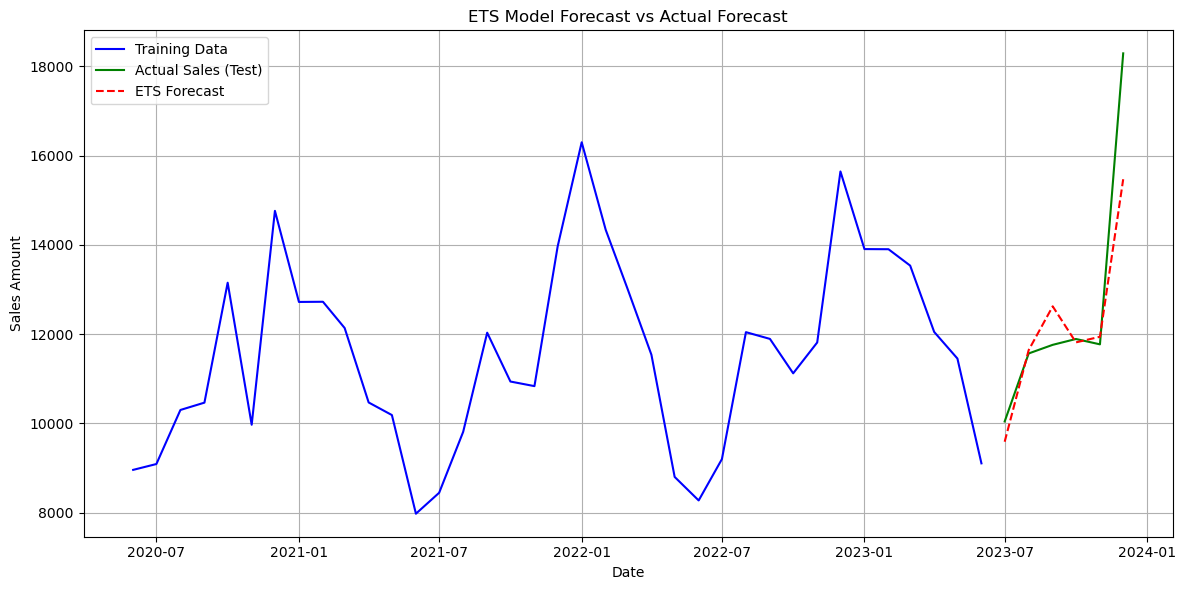

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12 , 6))
plt.plot(train_data.index , train_data["SalesAmount"] , label = "Training Data" , color = "blue")
plt.plot(test_data.index , test_data["SalesAmount"] , label = "Actual Sales (Test)" , color = "green")
plt.plot(test_data.index , ets_forecast, label = "ETS Forecast" , color = "red" , linestyle = "--")

plt.title("ETS Model Forecast vs Actual Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## SARIMA Modelling

In [58]:
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(
    train_data["SalesAmount"],
    order = (1 , 1 , 1 ),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit()

sarima_forecast = sarima_model.forecast(steps = len(test_data))

# Evaluating

from sklearn.metrics import mean_absolute_error , mean_squared_error
import numpy as np

sarima_mae = mean_absolute_error(test_data["SalesAmount"] , sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_data["SalesAmount"] , sarima_forecast))
sarima_mape = np.mean(np.abs((test_data["SalesAmount"] - sarima_forecast) / test_data["SalesAmount"])) * 100

print(f"SARIMA Model - MAE: {sarima_mae:.2f} , RMSE : {sarima_rmse:.2f} , MAPE : {sarima_mape:.2f}%")

SARIMA Model - MAE: 3370.06 , RMSE : 4291.29 , MAPE : 24.25%


#### PLotting Forecast vs Actual

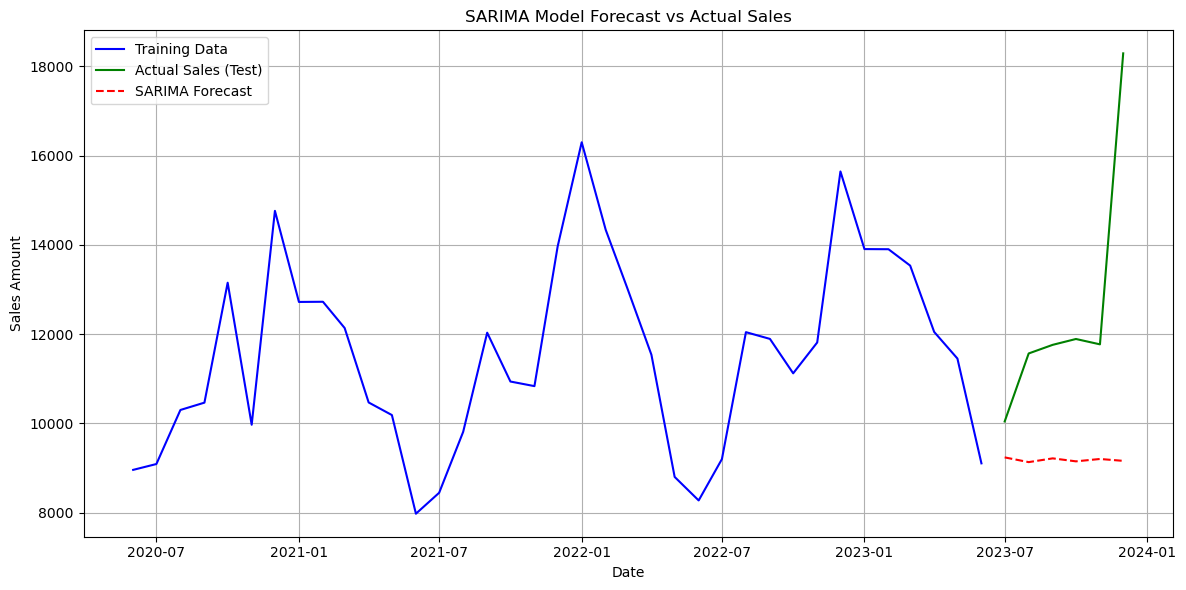

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12 , 6))
plt.plot(train_data.index , train_data["SalesAmount"] , label = "Training Data" , color = "blue")
plt.plot(test_data.index , test_data["SalesAmount"] , label = "Actual Sales (Test)" , color = "green")
plt.plot(test_data.index , sarima_forecast, label = "SARIMA Forecast" , color = "red" , linestyle = "--")

plt.title("SARIMA Model Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 2.9 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/13.3 MB 2.8 MB/s eta 0:00:05
   --- ------------------------------------ 1.3/13.3 MB 1.9 MB/s eta 0:00:07
   ------ --------------------------------- 2.1/13.3 MB 2.7 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/13.3 MB 2.6 MB/s eta 0:00:04
   ---------- ----------------------------- 3.4/13.3 MB 2.7 MB/s eta 0:00:04
   ----------- ---------------------------- 3.9/13.3 MB 2.6 MB/s eta 0:00:04
   ------------- -------------------------- 4.5/13.3 MB 2.6 MB/s eta 0:00:04
   -------------- ------------------------- 4.7/13.3 MB 2.7 MB/s eta 0:00:04
   ---------------- ----------------------- 5.5/13.3 MB 2.7 MB/s eta 0:00:03
   ------------------ --------------------- 6.0/13.3 MB 2.6 MB/s eta 0:00:03
   -------------------- ------------------- 6.8/13.3 MB 2.6 MB/s eta 0:00:03
   ---

In [74]:
from prophet import Prophet

prophet_train = train_data.reset_index()[["Date" , "SalesAmount"]]
prophet_train.rename(columns = {"Date": "ds" , "SalesAmount": "y"} , inplace = True)

prophet_model = Prophet()
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods = len(test_data) , freq = "MS")
forecast = prophet_model.predict(future)

prophet_forecast = forecast.set_index("ds")["yhat"].loc[test_data.index]

y_true = test_data["SalesAmount"]
y_pred = prophet_forecast

# Evaluating

from sklearn.metrics import mean_absolute_error , mean_squared_error
import numpy as np

mae = mean_absolute_error(y_true , y_pred)
rmse = np.sqrt(mean_squared_error(y_true , y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Prophet Model - MAE: {mae:.2f} , RMSE : {rmse:.2f} , MAPE : {mape:.2f}%")

08:41:42 - cmdstanpy - INFO - Chain [1] start processing
08:41:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model - MAE: 1527.32 , RMSE : 1635.99 , MAPE : 11.84%


#### Plotting Prophet Model

In [80]:
print(sales_data.columns)

Index(['SalesAmount', 'Promotion', 'HolidayMonth', 'Lag_1', 'Lag_2', 'Lag_3',
       'RollingMean_3', 'RollingMean_6', 'IsPromo', 'IsHoliday'],
      dtype='object')


09:12:37 - cmdstanpy - INFO - Chain [1] start processing
09:12:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecasr for next 6 months
           ds          yhat    yhat_upper    yhat_lower
43 2023-08-01  15354.855081  16188.661646  14548.326079
44 2023-09-01  14404.508692  15275.579457  13506.446040
45 2023-10-01  13646.724966  14558.344459  12817.297836
46 2023-11-01  12137.266112  12976.815847  11258.925938
47 2023-12-01  10626.164858  11444.765564   9776.425494
48 2024-01-01  10401.832570  11267.141912   9546.943418


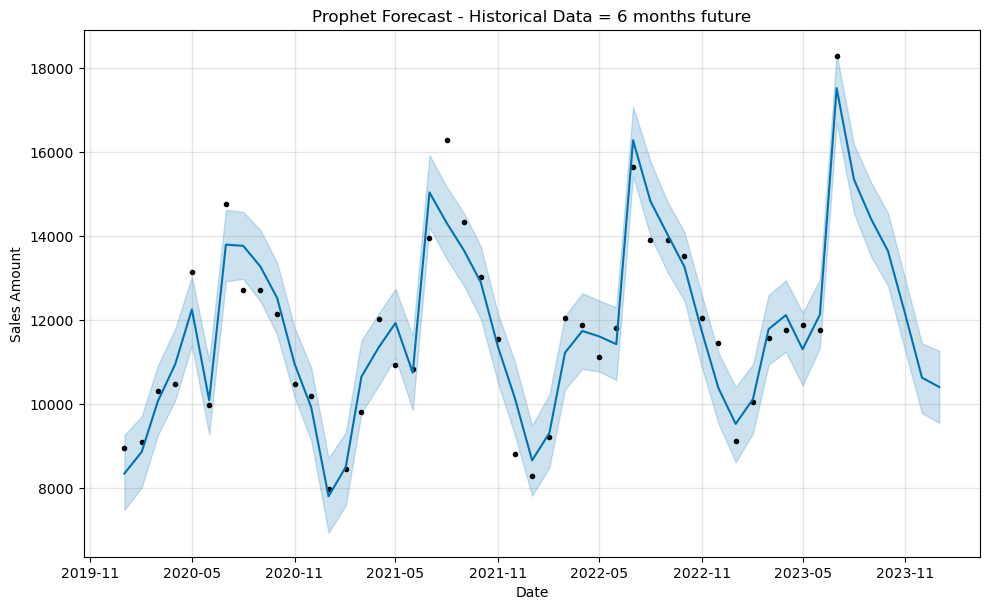

In [84]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

sales_data["Date"] = pd.date_range(start="2020-01-01", periods=len(sales_data), freq="MS")

df_prophet = sales_data[["Date" , "SalesAmount"]].copy()
df_prophet.rename(columns = {"Date": "ds" ,"SalesAmount": "y"} , inplace = True)

prophet_model = Prophet()
prophet_model.fit(df_prophet)

future = prophet_model.make_future_dataframe(periods = 6 , freq = "MS")
forecast = prophet_model.predict(future)

future_forecast = forecast[forecast["ds"] > df_prophet["ds"].max()][["ds" , "yhat" , "yhat_upper" , "yhat_lower"]]

print("Prophet forecasr for next 6 months")
print(future_forecast)

fig = prophet_model.plot(forecast)
plt.title("Prophet Forecast - Historical Data = 6 months future")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.show()

In [90]:
print(ets_forecast_df.columns)

Index(['Date', 'Forecat'], dtype='object')


# Best Model

C:\Users\Muneeb Ur Rehman\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Muneeb Ur Rehman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


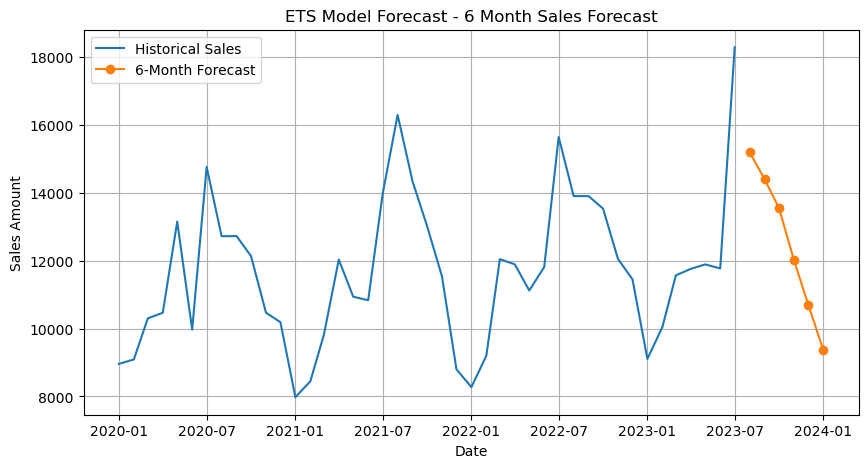

ETS Forecast for next 6 months
        Date      Forecast
0 2023-08-01  15197.579476
1 2023-09-01  14400.923272
2 2023-10-01  13546.595905
3 2023-11-01  12007.497875
4 2023-12-01  10686.870530
5 2024-01-01   9355.253672


In [92]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

sales_data["Date"] = pd.to_datetime(sales_data["Date"])

full_data = sales_data.copy()
full_data.index = pd.to_datetime(full_data["Date"])

ets_model_full = ExponentialSmoothing(full_data["SalesAmount"] , trend = "add" , seasonal = "add" , seasonal_periods = 12).fit() 
ets_forecast = ets_model_full.forecast(steps = 6)

future_dates = pd.date_range(full_data.index[-1] + pd.DateOffset(months = 1) , periods = 6 , freq = "MS")
ets_forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast" : ets_forecast.values
})
# Plotting Figure

plt.figure(figsize = (10 , 5))
plt.plot(full_data.index , full_data["SalesAmount"] , label = "Historical Sales")
plt.plot(ets_forecast_df["Date"] , ets_forecast_df["Forecast"] , label = "6-Month Forecast" , marker = "o")
plt.title("ETS Model Forecast - 6 Month Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.legend()
plt.show()

print("ETS Forecast for next 6 months")
print(ets_forecast_df)

In [93]:
# Save to CSV
sales_data.to_csv('retail_sales_mock_data.csv', index=False)
print("Mock retail sales data generated: retail_sales_mock_data.csv")
print(sales_data.head())

Mock retail sales data generated: retail_sales_mock_data.csv
            SalesAmount  Promotion  HolidayMonth    Lag_1    Lag_2    Lag_3  \
Date                                                                          
2020-06-01         8958          1             0   7783.0  14030.0  12722.0   
2020-07-01         9089          0             0   8958.0   7783.0  14030.0   
2020-08-01        10300          0             0   9089.0   8958.0   7783.0   
2020-09-01        10464          0             0  10300.0   9089.0   8958.0   
2020-10-01        13151          1             0  10464.0  10300.0   9089.0   

            RollingMean_3  RollingMean_6  IsPromo  IsHoliday       Date  
Date                                                                     
2020-06-01        10257.0   11458.666667        1          0 2020-01-01  
2020-07-01         8610.0   10932.166667        0          0 2020-02-01  
2020-08-01         9449.0   10480.333333        0          0 2020-03-01  
2020-09-01     

In [95]:
sales_data.to_csv('retail_sales_mock_data.csv', index=False)

In [102]:
import joblib
joblib.dump(ets_model_full , "ets_model.pkl")

['ets_model.pkl']